In [7]:
# libraries
import numpy as np
import keras
import os

# plot
from matplotlib import pyplot as plt

keras.__version__

'2.2.4'

# 6.3 Advanced use of recurrent neural networks 

Three advanced techniques for improving the performance and generalization power of recurrent neural networks in Keras: 

- **Recurrent dropout** - Built-in way to use dropout to fight overfitting in recurrent layers. 
- **Stacking recurrent layers** - This increases the representational power of the network (at the cost of higher computational loads)
- **Bididrectional recurrent layers** - These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues. 

#### A temperature - forecasting problem

- Weather timeseries dataset recorded 
 - 14 different quantities (air temperature, atmospheric pressure,...) 
 - recorded every 10 minutes
 - 2009-2016 (subset of original data)

In [5]:
# determine data origin
data_dir = "../data/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


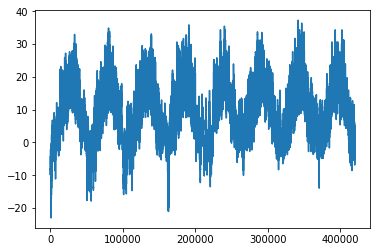

In [8]:
# Convert to numpy
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
# Plot the data
temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

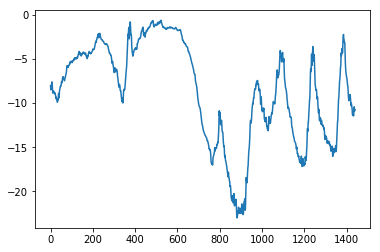

In [9]:
# first 10 days 
plt.plot(range(1440), temp[:1440])
plt.show()

- The plot shows daily periodicity, especially for the last 4 days. 

#### Preparing the data

Given data going as far back as `lookback` timesteps (1 timestep is 10 minutes) and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps?

- `lookback = 720`: Observations will go back 5 days 
 - `24 [hours] * 6 [timesteps per hour] * 5 [days]`
- `steps = 6` : Observations will be sampled at one data point per hour. 
- `delay = 144`: Targets will be 24 hours in the future

To do: 

- Preprocess data for NN.
 - Scale the data (Normalization)
- Write a python generator 
 - Takes current array of float data and yields batches of data from the recent past, along with a target temperature in the future. 
 - Generate samples on the fly using the original data.
 
Preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. 

Only the first 200,000 timesteps are used for training, hence data only need to be normalized according to these data. 

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Create data generator. It yields a tuple `(samples, targets)`. 

- `data`: Original array of floating point data
- `lookback`: How many timesteps back should our input data go. 
- `delay`: How many timesteps in the future should our target be. 
- `min_index` and `max_index`: Indices in the data array that delimit which timesteps to draw from.
- `shuffle`: Whether to shuffle our samples or draw them in chronological order
- `batch_size`: The number of samples per batch.
- `step`: The period, in timesteps, at which we sample data. We will set it to 6 in order to draw one data point every hour. 

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Instantiate three generators:

- training generator
- validation
- testing

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
print("val_steps:", val_steps)
print("test_steps:", test_steps)

val_steps: 769
test_steps: 930


#### A common-sense, non-machine learning baseline

- Predict that temperature 24 hours from now will be equal to the current temperature (snaive) as baseline. 
- Calculate Mean Absolute Error metric (MAE).

In [9]:
# function to get MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return(np.mean(batch_maes))
    
MAE = evaluate_naive_method()

In [10]:
print("MAE: ",MAE.round(4))

MAE:  0.2897


### A basic ML approach

- Try a simple and cheap ML model first
- Proceed to more complicated ones to compare performance improvements
- MAE will be used as loss

In [11]:
# imports
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# model
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

# compile the model 
model.compile(optimizer=RMSprop(), loss='mae')

# fit the model
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 27s 54ms/step - loss: 1.7218 - val_loss: 1.2535
Epoch 2/20
500/500 [==============================] - 25s 50ms/step - loss: 0.6735 - val_loss: 0.3195
Epoch 3/20
500/500 [==============================] - 26s 51ms/step - loss: 0.3332 - val_loss: 0.3376
Epoch 4/20
500/500 [==============================] - 26s 52ms/step - loss: 0.2823 - val_loss: 0.3100
Epoch 5/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2640 - val_loss: 0.3301
Epoch 6/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2513 - val_loss: 0.3561
Epoch 7/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2411 - val_loss: 0.3250
Epoch 8/20
500/500 [==============================] - 24s 49ms/step - loss: 0.2341 - val_loss: 0.3111
Epoch 9/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2333 - val_loss: 0.3268
Epoch 10/20
500/500 [==============================] - 24s 49ms/step - loss: 0.224

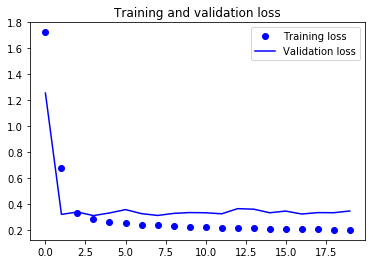

In [12]:
# Plot the results 
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The loss of this model is higher than our previous naive baseline. It seems as if the ML model is not able to capture the underlying process very good. 

Why doesn't the model find at least the baseline and achieve respective accuracy?

- Model is not looking for this simple solution

The space of models in which we are searching for a solution, i.e. the hypothesis space is the space of all possible 2-layer networks with the configuration that we defined. 

- When looking for a solution with a space of complicated models, the simple well-performing baseline might be unlearnable
- Learning algorithm may be hard-coded to look for a specific kind of simple model

### A first recurrent baseline

Previous model flattened the timeseries, which essentially removed the notion of time from the input data. 

Now, we'll use a model that takes order into account. 

We'll use the GRU layer, developed by Cho et al. (2014).

> Gated recurrent units (GRU) work by leveraging the same principle as LSTM, but they are somewaht streamlined and thus cheaper to run. 

- Tradeoff between computational expensiveness and representational power. 

In [13]:
# Recurrent NN
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# model with GRU layer
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

# compile 
model.compile(optimizer=RMSprop(), loss='mae')

# fit the model 
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s 343ms/step - loss: 0.3027 - val_loss: 0.2696
Epoch 2/20
500/500 [==============================] - 167s 333ms/step - loss: 0.2834 - val_loss: 0.2680
Epoch 3/20
500/500 [==============================] - 171s 342ms/step - loss: 0.2786 - val_loss: 0.2658
Epoch 4/20
500/500 [==============================] - 187s 374ms/step - loss: 0.2727 - val_loss: 0.2667
Epoch 5/20
500/500 [==============================] - 208s 416ms/step - loss: 0.2673 - val_loss: 0.2668
Epoch 6/20
500/500 [==============================] - 175s 350ms/step - loss: 0.2644 - val_loss: 0.2721
Epoch 7/20
500/500 [==============================] - 179s 359ms/step - loss: 0.2596 - val_loss: 0.2678
Epoch 8/20
500/500 [==============================] - 175s 351ms/step - loss: 0.2535 - val_loss: 0.2678
Epoch 9/20
500/500 [==============================] - 176s 353ms/step - loss: 0.2481 - val_loss: 0.2720
Epoch 10/20
500/500 [==============================] - 204s 407m

C:\Users\TM\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279847). Check your callbacks.
  % delta_t_median)


500/500 [==============================] - 177s 354ms/step - loss: 0.2220 - val_loss: 0.2864
Epoch 16/20
500/500 [==============================] - 176s 352ms/step - loss: 0.2208 - val_loss: 0.2862
Epoch 17/20
500/500 [==============================] - 179s 359ms/step - loss: 0.2145 - val_loss: 0.2901
Epoch 18/20
500/500 [==============================] - 233s 467ms/step - loss: 0.2131 - val_loss: 0.2885
Epoch 19/20
500/500 [==============================] - 360s 719ms/step - loss: 0.2099 - val_loss: 0.2969
Epoch 20/20
500/500 [==============================] - 386s 773ms/step - loss: 0.2059 - val_loss: 0.2955


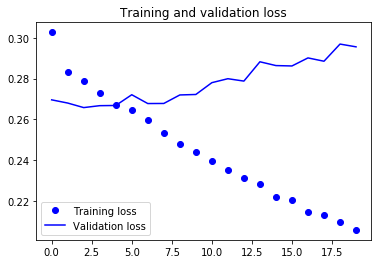

In [14]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model now performs better than naive baseline before overfitting. We'll approach this problem in a next step by including recurrent droput

### Using recurrent dropout to fight overfitting. 

- Model is overfitting
- Classic technique against it: Dropout
 - Dropout: RAndomly zeroing-out input units
- Dropout in recurrent networks is more complicated
 - Use same dropout mask (same pattern of dropped units) with at every timestep
 - Temporally constant dropout mask should be applied to the inner recurrent activations ("recurrent" dropout mask).
 - Using same dropout mask allows network to properly propagate its learning error through time, whereas a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process. 
- Recurrent layer has two dropout-related arguments:
 - `dropout`: float specifying dropout rate of the recurrent units
 - `recurrent_dropout`specifying the dropout rate of the recurrent units. 
 
Apply dropout and recurrent dropout to GRU layer. How does this impact overfitting?

In [15]:
# imports 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# define model
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

# compile specifications
model.compile(optimizer=RMSprop(), loss='mae')

# fit model
history = model.fit_generator(train_gen,
                              steps_per_epoch=128,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
128/128 [==============================] - 229s 2s/step - loss: 0.3925 - val_loss: 0.2877
Epoch 2/40
128/128 [==============================] - 186s 1s/step - loss: 0.3340 - val_loss: 0.2807
Epoch 3/40
128/128 [==============================] - 182s 1s/step - loss: 0.3211 - val_loss: 0.2757
Epoch 4/40
128/128 [==============================] - 199s 2s/step - loss: 0.3215 - val_loss: 0.2770
Epoch 5/40
128/128 [==============================] - 225s 2s/step - loss: 0.3166 - val_loss: 0.2756
Epoch 6/40
128/128 [==============================] - 138s 1s/step - loss: 0.3116 - val_loss: 0.2761
Epoch 7/40
128/128 [==============================] - 116s 910ms/step - loss: 0.3128 - val_loss: 0.2736
Epoch 8/40
128/128 [==============================] - 119s 926ms/step - loss: 0.3112 - val_loss: 0.2742
Epoch 9/40
128/128 [==============================] - 135s 1s/step - loss: 0.3070 - val_loss: 0.2717
Epoch 10/40
128/128 [==============================] - 95s 741ms/step - loss: 0.3115 

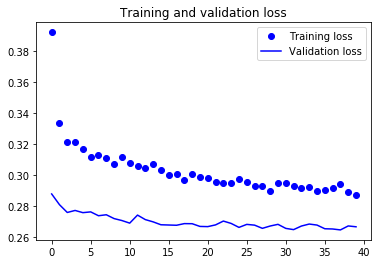

In [16]:
# plot
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Stacking recurrent layers

- Stable performance and no longer overfitting
- Validation loss not much better than before. 

Is there a performance bottleneck? If yes, stack additional recurrent layers.

- Increase capacity of the network until overfitting becomes the primary obstacle
- To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. 
 - I.e. `return_sequences=True`

In [22]:
float_data.shape

(420551, 14)

In [32]:
# Imports 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# build the model
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation="relu",
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

# compile the model
model.compile(optimizer=RMSprop(), loss="mae")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 32)          4512      
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                18624     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


#### Notes: Alternative formulation

- import functions directly
- use activation layer instead of specifying it (same result, more flexibility)
- `input_dim=14` is equivalent to `input_shape=(None, 14)` 
 - ...input_dim is deprecated...

In [35]:
from keras.layers import Dense, GRU, Activation

# Alternative formulation of the model
model = Sequential([
    GRU(32,
        dropout=0.1,
        recurrent_dropout=0.5,
        return_sequences=True,
        input_shape=(None, float_data.shape[-1])),
    GRU(64,
        dropout=0.1,
        recurrent_dropout=0.5),
    Activation("relu"),
    Dense(1)    
])

# compile the model 
model.compile(optimizer=RMSprop(),
             loss="mae")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, None, 32)          4512      
_________________________________________________________________
gru_17 (GRU)                 (None, 64)                18624     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Fit the model (for now, only 5 epochs, later up to 40?)
history = model.fit_generator(train_gen,
                              steps_per_epoch = 128, 
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
128/128 [==============================] - 265s 2s/step - loss: 0.3709 - val_loss: 0.2897
Epoch 2/40
128/128 [==============================] - 258s 2s/step - loss: 0.3350 - val_loss: 0.2829
Epoch 3/40
128/128 [==============================] - 265s 2s/step - loss: 0.3234 - val_loss: 0.2825
Epoch 4/40
128/128 [==============================] - 265s 2s/step - loss: 0.3229 - val_loss: 0.2780
Epoch 5/40
128/128 [==============================] - 264s 2s/step - loss: 0.3203 - val_loss: 0.2782
Epoch 6/40
128/128 [==============================] - 271s 2s/step - loss: 0.3176 - val_loss: 0.2740
Epoch 7/40
128/128 [==============================] - 271s 2s/step - loss: 0.3089 - val_loss: 0.2744
Epoch 8/40
128/128 [==============================] - 260s 2s/step - loss: 0.3128 - val_loss: 0.2740
Epoch 9/40
128/128 [==============================] - 270s 2s/step - loss: 0.3106 - val_loss: 0.2724
Epoch 10/40
128/128 [==============================] - 277s 2s/step - loss: 0.3095 - val_lo

KeyboardInterrupt: 

In [ ]:
# plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Notes

- No significant improvements 
- As long as overfitting is not too bad we can increase the size of our layers (this does have a non-negligible computational cost!!!)
- Since adding a layer did not help we may be seeing diminishing returns to increasing network capacity at this point. 

## Using bidirectional RNNs

- Common variant which may yield better performance on certain tasks

> Bidirectional RNNs are frequently used in natural language processing and processes a sequence both way. Thus, bidirectional RNN is able to catch patterns that may have been overlooked by a one-directional RNN. 

For time series reversing the order does not improve the resuls. This is reasoanble as the underlying GRU layer typically be better at remembering the recent past than the distant past. More recent data in time series are generally more predictive than older data points. This is not always the case, as we'll see for the IMDB text data.

#### Reversing the order of the IMDB data 

In [37]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# Define model
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 246s 12ms/step - loss: 0.3800 - acc: 0.8457 - val_loss: 0.3582 - val_acc: 0.8590
Epoch 2/10
20000/20000 [==============================] - 248s 12ms/step - loss: 0.2851 - acc: 0.8923 - val_loss: 0.3191 - val_acc: 0.8670
Epoch 3/10
20000/20000 [==============================] - 242s 12ms/step - loss: 0.2411 - acc: 0.9116 - val_loss: 0.3608 - val_acc: 0.8552
Epoch 4/10
20000/20000 [==============================] - 282s 14ms/step - loss: 0.2109 - acc: 0.9254 - val_loss: 0.3430 - val_acc: 0.8722
Epoch 5/10
20000/20000 [==============================] - 350s 17ms/step - loss: 0.1841 - acc: 0.9356 - val_loss: 0.3279 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 356s 18ms/step - loss: 0.1662 - acc: 0.9421 - val_loss: 0.3382 - val_acc: 0.8756
Epoch 7/10
20000/20000 [==============================] - 327s 16ms/step - loss: 0.1557 - acc: 0.9480 - val_loss: 0.5

#### Notes

- Near-identical performance than chronological data
- It seems that word order does matter but not which order
- Different yet useful representation of the data. 
 - Can be useful for example in *ensembling*

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs and looks at its inputs seqeunce both ways. 

The bidirectional RNN in Keras can be used using the `Bidirectional` layer, which takse as first argument a recurrent alyer instance. 

In [40]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 344s 17ms/step - loss: 0.5408 - acc: 0.7331 - val_loss: 0.3474 - val_acc: 0.8688
Epoch 2/10
20000/20000 [==============================] - 323s 16ms/step - loss: 0.3162 - acc: 0.8772 - val_loss: 0.3708 - val_acc: 0.8766
Epoch 3/10
20000/20000 [==============================] - 345s 17ms/step - loss: 0.2567 - acc: 0.9071 - val_loss: 0.3291 - val_acc: 0.8678
Epoch 4/10
20000/20000 [==============================] - 403s 20ms/step - loss: 0.2216 - acc: 0.9197 - val_loss: 0.3150 - val_acc: 0.8806
Epoch 5/10
20000/20000 [==============================] - 312s 16ms/step - loss: 0.2089 - acc: 0.9283 - val_loss: 0.3297 - val_acc: 0.8858
Epoch 6/10
20000/20000 [==============================] - 357s 18ms/step - loss: 0.1875 - acc: 0.9341 - val_loss: 0.3257 - val_acc: 0.8736
Epoch 7/10
20000/20000 [==============================] - 492s 25ms/step - loss: 0.1647 - acc: 0.9425 - val_loss: 0.3

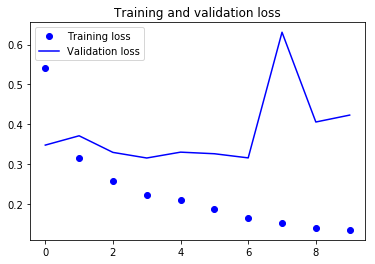

In [41]:
# plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Notes

- Slightly better performance of the bidirectional layer
- This model seems to overfit which could be approached (note that we now have twice the numbers of parameters increasing the likelihood of overfitting). 

## Going further

Things to try to improve the performance the weather forecasting problem. 

- Adjust the number of units in each recurrent layer in the stacked setup. Choices are largely arbitrary and thus likely suboptimal. 
- Adjusting the learning rate used by RMSprop optimizer
- Try using `LSTM`layers instead of GRU layers. 
- Try using a bigger denseley-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layre of even a stack of `Dense`layers. 
- Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set

In [42]:
print("Done!")

Done!
